In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib, shlex, subprocess
import xbout
import scipy
import xhermes
from xhermes import *


sys.path.append(r"/users/jpm590/2dspace/post-processing/sdtools/")


from hermes3.utils import *


from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.selectors import *

%load_ext autoreload
%autoreload 2
print("Done")
import hermes3



Done


In [2]:
db = CaseDB(
    case_dir = r"/users/jpm590/scratch/",
        # case_dir = r"/users/jpm590/2dspace/run",

    grid_dir = r"/users/jpm590/2dspace/hermes-3/build-mc-master"
)

toload = [
    dict(name="MAST-U", id="251007-2D-MASTU", unnormalise_geom = True, use_xhermes = True, squash = True)
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()
    

- Reading case 251007-2D-MASTU
-----------------------
- Looking for squash file
- Squash file found. squash date 10/17/2025, 15:41:40, dmp file date 10/16/2025, 00:59:55

Unnormalising with xHermes


## Plot different times steps

Use `ds.isel(t=index)` for time index

Use `ds.sel(t=index)` for real time 


In [22]:
ds_all = cs["MAST-U"].ds
ds_final = cs["MAST-U"].ds.isel(t=-1)

t_vals = ds_all.t.values
total_time = len(t_vals)
final_time = ds_final.t.values

print(f"Total number of time steps: {total_time} at real time {final_time:.3f} s")
ds_1000 = cs["MAST-U"].ds.isel(t=1000)
# ds_2000 = cs["MAST-U"].ds.isel(t=2000)
# ds_3000 = cs["MAST-U"].ds.isel(t=3000)
ds_5000 = cs["MAST-U"].ds.isel(t=5000)
# I must changed the timestep from 0.01 to 0.1 at some point ...
ds_5684 = cs["MAST-U"].ds.isel(t=5684)


ds_array = [ds_1000,  ds_5000, ds_final]
ds_realtime= []
for i in ds_array:
    real_time = i.t.values
    print(f"The real time is {real_time}")
    ds_realtime.append(real_time)


Total number of time steps: 5685 at real time 0.105 s
The real time is 0.010009129187926557
The real time is 0.050005649419395726
The real time is 0.10535083428969766


### Plot temperature versus time (check convergence)

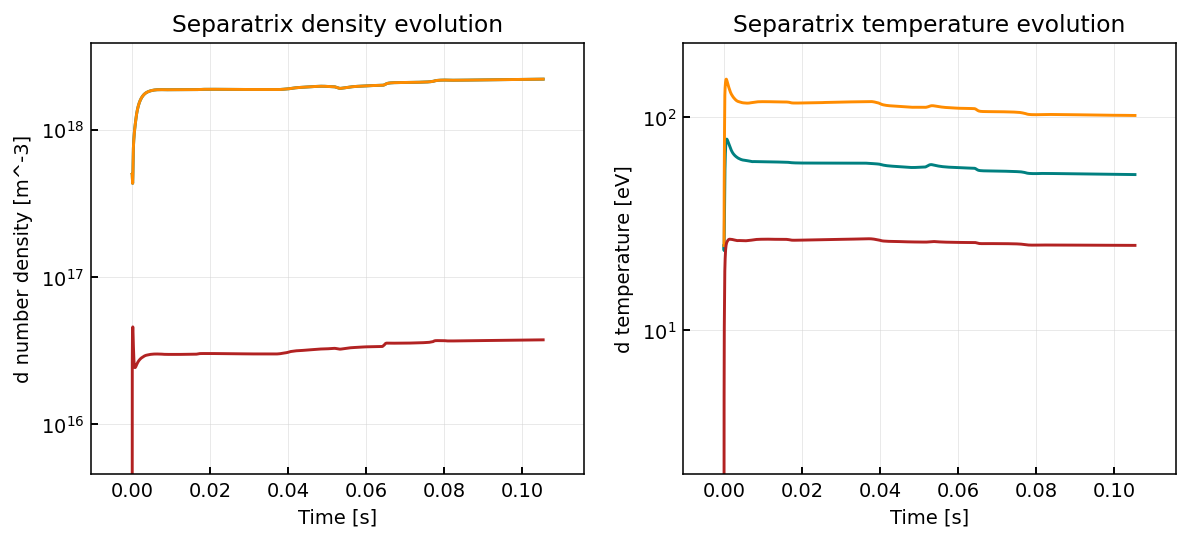

In [20]:

fig, ax = plt.subplots(1,2, figsize=(10,4))
ds_all.hermesm.select_region("outer_midplane_a_sep")["Ne"].plot(ax=ax[0], label="Ne")
ds_all.hermesm.select_region("outer_midplane_a_sep")["Nd+"].plot(ax=ax[0],label="Nd+")
ds_all.hermesm.select_region("outer_midplane_a_sep")["Nd"].plot(ax=ax[0], label="Nd")

ds_all.hermesm.select_region("outer_midplane_a_sep")["Te"].plot( ax=ax[1], label = "Te")
ds_all.hermesm.select_region("outer_midplane_a_sep")["Td+"].plot(ax=ax[1], label = "Td+")
ds_all.hermesm.select_region("outer_midplane_a_sep")["Td"].plot( ax=ax[1], label = "Td")

ax[0].set_yscale("log")
ax[0].set_title("Separatrix density evolution")
ax[0].grid(True, alpha = 0.5)


ax[1].set_yscale("log")
ax[1].set_title("Separatrix temperature evolution")
ax[1].grid(True, alpha = 0.5)


# fig, ax = plt.subplots(1, 2, figsize = (10,6))
# ax[0].plot(df_fieldline.t.values, df_fieldline["Te"])

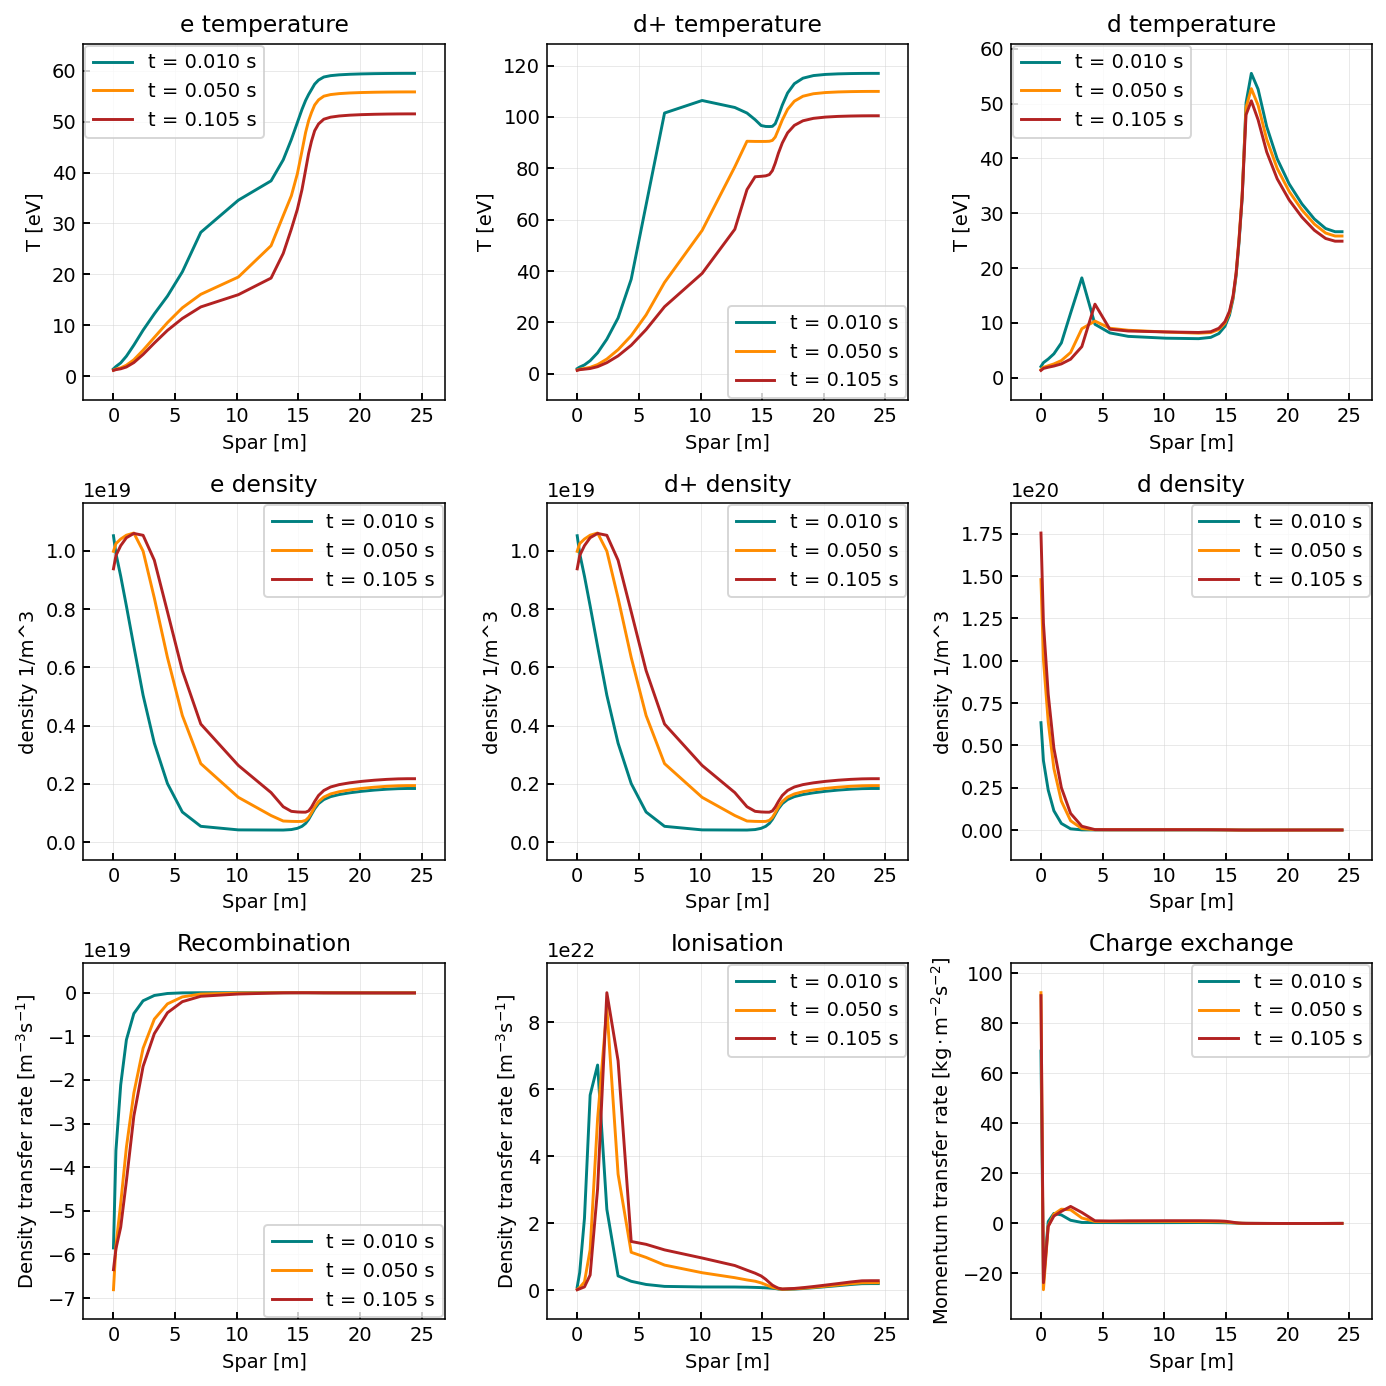

In [39]:
fig, ax = plt.subplots(3,3, figsize = (10,10))

for i, ds in enumerate(ds_array):
    df_fieldline = get_1d_poloidal_data(
        ds, 
        params = ["Te", "Td+", "Td", "Ne", "Nd+", "Nd", "Sd+_iz", "Sd+_rec", "Fdd+_cx"], 
        region = "outer_lower", 
        sepadd=1
    )

    ax[0,0].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Te"], label = f"t = {ds_realtime[i]:.3f} s" )
    ax[0,0].set_title("e temperature")
    ax[0,0].set_xlabel("Spar [m]")
    ax[0,0].set_ylabel("T [eV]")
    ax[0,0].legend()
    ax[0,0].grid(True, alpha=0.5)
    
    
    
    ax[0,1].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Td+"], label = f"t = {ds_realtime[i]:.3f} s" )
    ax[0,1].set_title("d+ temperature")
    ax[0,1].set_xlabel("Spar [m]")
    ax[0,1].set_ylabel("T [eV]")
    ax[0,1].legend()
    ax[0,1].grid(True, alpha=0.5)
    
    
    ax[0,2].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Td"], label = f"t = {ds_realtime[i]:.3f} s" )
    ax[0,2].set_title("d temperature")
    ax[0,2].set_xlabel("Spar [m]")
    ax[0,2].set_ylabel("T [eV]")
    ax[0,2].legend()
    ax[0,2].grid(True, alpha=0.5)
    
    ### Density 
    
    ax[1,0].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Ne"], label = f"t = {ds_realtime[i]:.3f} s" )
    ax[1,0].set_title("e density")
    ax[1,0].set_xlabel("Spar [m]")
    ax[1,0].set_ylabel("density 1/m^3")
    ax[1,0].legend()
    ax[1,0].grid(True, alpha=0.5)
    
    
    ax[1,1].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Nd+"], label = f"t = {ds_realtime[i]:.3f} s" )
    ax[1,1].set_title("d+ density")
    ax[1,1].set_xlabel("Spar [m]")
    ax[1,1].set_ylabel("density 1/m^3")
    ax[1,1].legend()
    ax[1,1].grid(True, alpha=0.5)
    
    
    ax[1,2].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Nd"], label = f"t = {ds_realtime[i]:.3f} s" )
    ax[1,2].set_title("d density")
    ax[1,2].set_xlabel("Spar [m]")
    ax[1,2].set_ylabel("density 1/m^3")
    ax[1,2].legend()
    ax[1,2].grid(True, alpha=0.5)
    
    ### Reactions
    ax[2,0].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Sd+_rec"], label = f"t = {ds_realtime[i]:.3f} s" )
    ax[2,0].set_title("Recombination")
    ax[2,0].set_xlabel("Spar [m]")
    ax[2,0].set_ylabel("Density transfer rate [$m^{-3}s^{-1}$]")
    ax[2,0].legend()
    ax[2,0].grid(True, alpha=0.5)
    
    
    ax[2,1].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Sd+_iz"], label = f"t = {ds_realtime[i]:.3f} s" )
    ax[2,1].set_title("Ionisation")
    ax[2,1].set_xlabel("Spar [m]")
    ax[2,1].set_ylabel("Density transfer rate [$m^{-3}s^{-1}$]")
    ax[2,1].legend()
    ax[2,1].grid(True, alpha=0.5)
    
    
    ax[2,2].plot(df_fieldline["Spar"].values[::-1], df_fieldline["Fdd+_cx"], label = f"t = {ds_realtime[i]:.3f} s" )
    ax[2,2].set_title("Charge exchange")
    ax[2,2].set_xlabel("Spar [m]")
    ax[2,2].set_ylabel("Momentum transfer rate [$kg \\cdot m^{-2}s^{-2}$]")
    ax[2,2].legend()
    ax[2,2].grid(True, alpha=0.5)
plt.tight_layout()

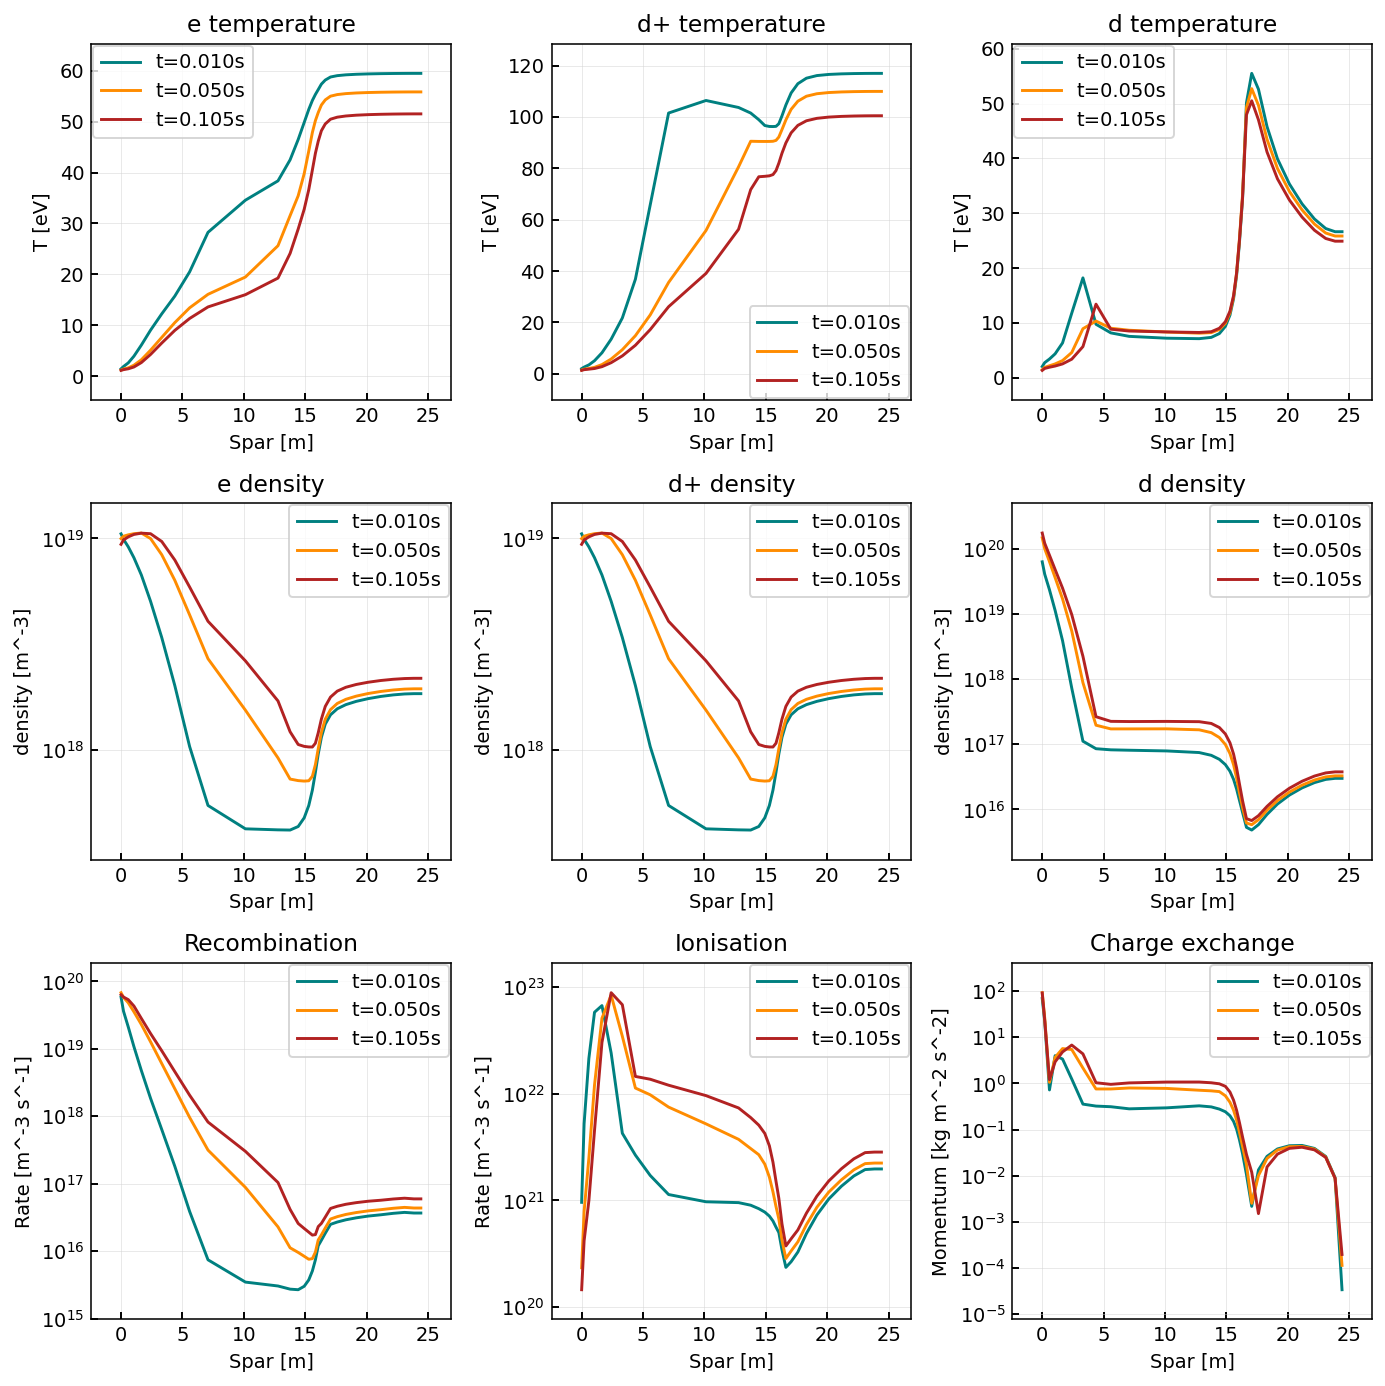

In [43]:
plots = [
    ("Te",      "e temperature",        "T [eV]",                    False),
    ("Td+",     "d+ temperature",       "T [eV]",                    False),
    ("Td",      "d temperature",        "T [eV]",                    False),
    ("Ne",      "e density",            "density [m^-3]",            True),
    ("Nd+",     "d+ density",           "density [m^-3]",            True),
    ("Nd",      "d density",            "density [m^-3]",            True),
    ("Sd+_rec", "Recombination",        "Rate [m^-3 s^-1]",          True),
    ("Sd+_iz",  "Ionisation",           "Rate [m^-3 s^-1]",          True),
    ("Fdd+_cx", "Charge exchange",      "Momentum [kg m^-2 s^-2]",   True),
]


fig, ax = plt.subplots(3,3, figsize=(10,10))

for i, ds in enumerate(ds_array):
    df = get_1d_poloidal_data(ds, params=[p[0] for p in plots], region="outer_lower", sepadd=1)
    
    for idx, (param, title, ylabel, logy) in enumerate(plots):
        r, c = divmod(idx, 3)
        axi = ax[r,c]

        axi.plot(np.abs(df["Spar"][::-1]), np.abs(df[param]), label=f"t={ds_realtime[i]:.3f}s")
        axi.set_title(title)
        axi.set_xlabel("Spar [m]")
        axi.set_ylabel(ylabel)
        axi.grid(True, alpha=0.5)

        if logy:
            axi.set_yscale("log")

for axi in ax.flat:
    axi.legend()

plt.tight_layout()
